#Drawing a Map from Pub Locations with the Matplotlib Basemap Toolkit

**Author**: [Ramiro Gómez](https://ramiro.org/)

In this notebook I show how you can draw a map of [Britain and Ireland](https://en.wikipedia.org/wiki/British_Isles) from location data using the [Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/). The data points that will be drawn are pub locations extracted from [OpenStreetMap](http://www.openstreetmap.org/) and provided by [osm-x-tractor](http://osm-x-tractor.org/Data.aspx).

When you download and extract the Points Of Interest (POI) dataset as a CSV file it has a file size of about 800 MB and more than 9 million entries for different types of locations. To filter out only the locations tagged as pubs you can use csvgrep, which is part of the [csvkit toolkit](http://csvkit.readthedocs.org/).

    csvgrep -c amenity -m pub POIWorld.csv > POIWorld-pub.csv
    
The resulting CSV file is much smaller with a size of 7.7 MB and contains a little more than 120,000 entries for pub locations all over the world. Since the coverage varies across countries and regions, I chose to limit the map to Britain and Ireland where POI coverage seems quite comprehensive and there are a lot of pubs. Who could have thought?

Next we load the required libraries and define a function that checks whether a given location tuple is within the given bounding box.

In [1]:
%load_ext signature
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap


def within_bbox(bbox, loc):
    """Determine whether given location is within given bounding box.
    
    Bounding box is a dict with ll_lon, ll_lat, ur_lon and ur_lat keys
    that locate the lower left and upper right corners.
    
    The loction argument is a tuple of longitude and latitude values.
    """
    
    return bbox['ll_lon'] < loc[0] < bbox['ur_lon'] and bbox['ll_lat'] < loc[1] < bbox['ur_lat']

The next statements load the pub dataset into a Pandas DataFrame, remove all columns that have missing values and print the length and the first few entries.

In [2]:
df = pd.read_csv('csv/POIWorld-pub.csv')
df.dropna(axis=1, how='any', inplace=True)
print(len(df))
df.head()

123379


,"﻿""osmid""",amenity,Longitude,Latitude
0,105,pub,-0.143209,51.523681
1,108042,pub,-0.135599,51.523544
2,262706,pub,-0.725178,51.035030
3,262707,pub,-0.854808,51.043900
4,262708,pub,-0.726258,51.024400


## Restrict dataset to actual pubs

Reddit user [kwwillett](https://www.reddit.com/user/kwwillett) pointed out that the dataset not only contains pubs [in a comment](https://www.reddit.com/r/MapPorn/comments/3erli3/britain_ireland_drawn_from_pubs_1144x1499_oc/ctibgig). The `csvgrep` call also matches strings containing it, see some examples below.

In [3]:
df.amenity.value_counts().head()

pub                94061
public_building    27544
public_hall          774
public_bookcase      465
public_bath          176
dtype: int64

This changes number of pubs significantly so we need to perform additional filtering.

In [4]:
df = df[df.amenity.str.match(r'\bpub\b')]
df.amenity.value_counts()

pub                    94061
pub;restaurant            12
pub;bar                    4
pub; restaurant            3
pub:demolished             2
pub;ktv                    1
pub,brewery                1
pub;atm;restaurant         1
pub;nightclub              1
pub;cafe;restaurant        1
pub;cafe;bar;lounge        1
pub food=no                1
pub;lottery                1
pub;bicycle_parking        1
dtype: int64

The remaining location classifications are good to include, so now we have the actual pubs of the world as covered by OpenStreetMap in July 2015.

## Limiting locations geographically

To limit the dataset and the displayed map to Britain and Ireland, we now create a dict with appropriate coordinates from the [GeoPlanet Explorer](http://isithackday.com/geoplanet-explorer/index.php?woeid=24865730) and filter the longitude and latitude values from the DataFrame that are within the bounding box. We end up with roughly 28,000 records, meaning that almost a quarter of the pubs in the POI dataset are located on Britain and Ireland.

In [5]:
bbox = {
    'lon': -5.23636,
    'lat': 53.866772,
    'll_lon': -10.65073,
    'll_lat': 49.16209,
    'ur_lon': 1.76334,
    'ur_lat': 60.860699
}

locations = [loc for loc in zip(df.Longitude.values, df.Latitude.values) if within_bbox(bbox, loc)]
len(locations)

28139

##Drawing the map

Now we get to the actual drawing part. We set the size of the image and some variables for [marker diplay](http://matplotlib.org/api/markers_api.html), create a `Basemap` object using the [Miller Cylindrical Projection](http://matplotlib.org/basemap/users/mill.html) and the coordinates looked up before to center the map and limit the area. Also we make sure that the background is white and no border is printed around the map image.

The previously created list of location tuples is then unpacked into 2 lists of longitudes and latitudes, which are provided as arguments in the call to the Basemap instance. This converts the lon/lat values (in degrees) to x/y map projection coordinates (in meters). 

The location dots are drawn with the scatter method passing the x and y coordinate lists, and the marker display variables. The map is then annotated with a title that says what the map shows, a footer with information about the author and data source and finally displayed.

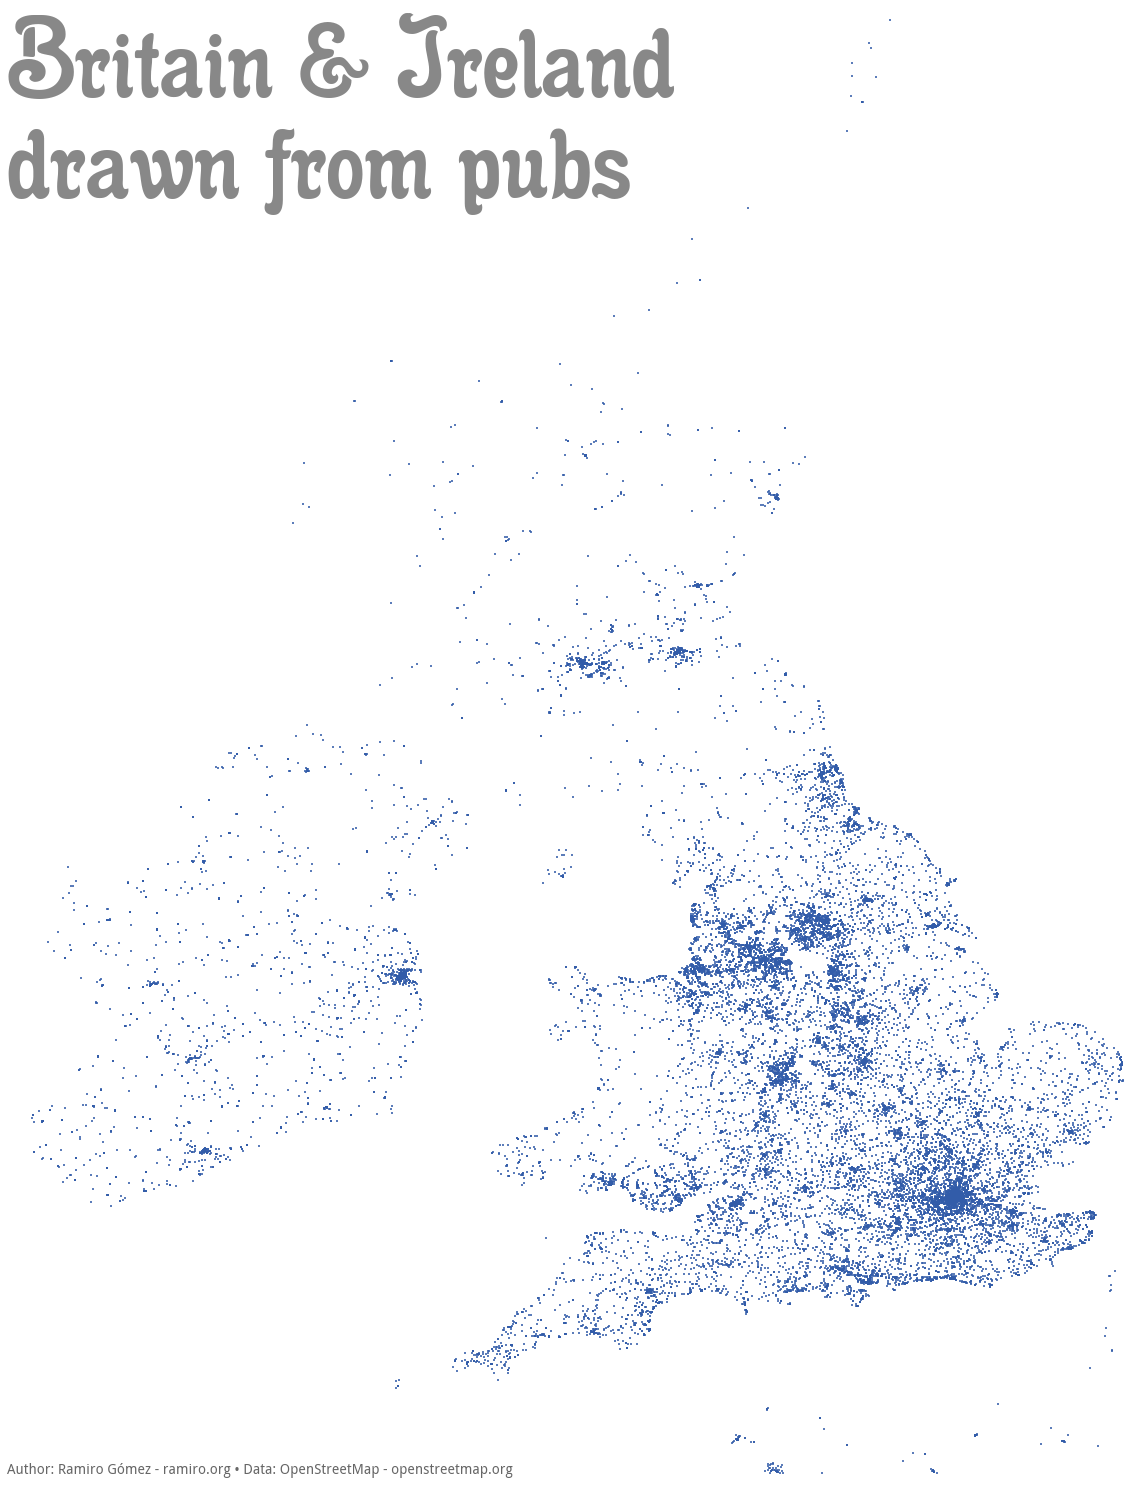

In [6]:
fig = plt.figure(figsize=(20, 30))
markersize = 1
markertype = ','  # pixel
markercolor = '#325CA9'  # blue
markeralpha = .8 #  a bit of transparency

m = Basemap(
    projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
    llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
    urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'])

# Avoid border around map.
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)

# Convert locations to x/y coordinates and plot them as dots.
lons, lats = zip(*locations)
x, y = m(lons, lats)
m.scatter(x, y, markersize, marker=markertype, color=markercolor, alpha=markeralpha)

# Set the map title.
plt.annotate('Britain & Ireland\ndrawn from pubs',
             xy=(0, .87),
             size=120, 
             xycoords='axes fraction',
             color='#888888', 
             family='Gloria')

# Set the map footer.
plt.annotate('Author: Ramiro Gómez - ramiro.org • Data: OpenStreetMap - openstreetmap.org', 
             xy=(0, 0), 
             size=14, 
             xycoords='axes fraction',
             color='#666666',
             family='Droid Sans')

plt.savefig('img/britain-ireland-drawn-from-pubs.png', bbox_inches='tight')

The resulting map of Britain and Ireland shows the contour of the islands and unsurprisingly which areas are more or less densely populated. A large version of the map is available as prints from [Redbubble](http://www.redbubble.com/people/ramiro/works/15675223-britain-and-ireland-drawn-from-pubs-map-print) and [Zazzle](http://www.zazzle.com/britain_ireland_drawn_from_pubs_map_print-228698914087902041?rf=238355915198956003&tc=r).

In [7]:
%signature